In [16]:
import dendropy
import os
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def compareTreesFromPath(treePath1, treePath2):
    print("Comparing {} with {}".format(treePath1, treePath2))
    
    tax = dendropy.TaxonNamespace()
    tr1 = dendropy.Tree.get(path=treePath1,
                            schema='newick',
                            rooting='force-unrooted',
                            taxon_namespace=tax,
                            preserve_underscores=True)
    tr2 = dendropy.Tree.get(path=treePath2,
                            schema='newick',
                            rooting='force-unrooted',
                            taxon_namespace=tax,
                            preserve_underscores=True)

    tr1.collapse_basal_bifurcation(set_as_unrooted_tree=True)
    tr2.collapse_basal_bifurcation(set_as_unrooted_tree=True)

    return compareDendropyTrees(tr1, tr2)
    #print("RF distance on %d shared leaves: %d" % (nl, fp + fn))

def compareDendropyTrees(tr1, tr2):
    from dendropy.calculate.treecompare \
        import false_positives_and_negatives

    lb1 = set([l.taxon.label for l in tr1.leaf_nodes()])
    lb2 = set([l.taxon.label for l in tr2.leaf_nodes()])
    
    com = lb1.intersection(lb2)
    if com != lb1 or com != lb2:
        com = list(com)
        tns = dendropy.TaxonNamespace(com)

        tr1.retain_taxa_with_labels(com)
        tr1.migrate_taxon_namespace(tns)

        tr2.retain_taxa_with_labels(com)
        tr2.migrate_taxon_namespace(tns)
    com = list(com)

    tr1.update_bipartitions()
    tr2.update_bipartitions()

    nl = len(com)
    ei1 = len(tr1.internal_edges(exclude_seed_edge=True))
    ei2 = len(tr2.internal_edges(exclude_seed_edge=True))

    [fp, fn] = false_positives_and_negatives(tr1, tr2)
    rf = float(fp + fn) / (ei1 + ei2)

    return (nl, ei1, ei2, fp, fn, rf)

In [ ]:
'''
This function will run under either jc model or gtr model with fastTree2
on each of the dataset file and compare the result with the real tree
Input: specify the model in string
       "-gtr": compute with gtr model
       "": compute with jc model
output: dictionary which key of the name of the dataset folder
        and value of the (nl, ei1, ei2, fp, fn, rf) 
        for each computed tree of each file compare to the real tree
'''
def run_FastTree2(model):
    model_path = model
    if model == '':
        model_path = 'jc'
    else:
        model_path = 'gtr'
    result = dict()
    data_fd = "data"
    for folder in os.listdir(data_fd):
        
        folder_fd = data_fd+"/"+folder+"/"+folder
        
        if not os.path.isdir(folder_fd):
            continue
        result[folder] = []

        for data_set in os.listdir(folder_fd):
                
            data_path = folder_fd + '/' +data_set
            if not os.path.isdir(data_path):
                continue
            result_path = "result/fastTree/"+folder+'/'+model_path
                
            if not os.path.isdir(result_path):
                os.makedirs(result_path)
            os.system("./FastTree {} -nt {}/rose.aln.true.fasta > {}".format(model, data_path, result_path+'/'+data_set))
            result[folder].append(compareTreesFromPath(result_path+'/'+data_set, data_path+"/rose.tt"))

    return result

In [ ]:
'''
This function will run under either p-distance, Logdet, or JC distance with fastme
on each of the dataset file and compare the result with the real tree
assume the data stored at path "data"
Input: dist: specify the distance in string
             "J": jc distance
             "p": p-distance
             "L": logdet
       folder: the name of the dataset folder
output: list of the (nl, ei1, ei2, fp, fn, rf) for each computed tree of 
        each file compare to the real tree
'''

def run_fastme(dist, folder):
    
    result = []
    
    folder_fd = "data/"+folder+"/"+folder
    
    for data_set in os.listdir(folder_fd):
        data_path = folder_fd + '/' +data_set
        if not os.path.isdir(data_path):
            continue
        result_path = "result/fastMe/"+folder+'/'+dist
            
        if not os.path.isdir(result_path):
            os.makedirs(result_path)
            
        os.system("fastme --method=N  --dna={} --input_data={}/rose.aln.true.phylip -o {}".format(dist, data_path, result_path+'/'+data_set))
        result.append(compareTreesFromPath(result_path+'/'+data_set, data_path+"/rose.tt"))

    return result

In [19]:
'''
compute the average fn and fp of a method and 
print the average by dataset
input: dictionary with dataset name as key,
       list of (nl, ei1, ei2, fp, fn, rf) compared with real tree as value
'''
def avg_fp_fn(result_dict):
    fp_rate = []
    fn_rate = []
    
    for key, item in result_dict.items():
        fp = []
        e_m = 0
        fn = []
        e_t = 0
        for tpl in item:
            fp.append(tpl[3])
            e_m += tpl[1]
            fn.append(tpl[4])
            e_t += tpl[2]

        fp_avg = sum(fp)/len(fp)
        fn_avg = sum(fn)/len(fn)
        
        fp_rate.append(sum(fp)/e_m)
        fn_rate.append(sum(fn)/e_t)

        print(key)
        print("avg false positive:", fp_avg, "std:", np.std(np.array(fp)), "rate:", sum(fp)/e_m)
        print("avg false negative:", fn_avg, "std:", np.std(np.array(fn)), "rate:", sum(fn)/e_t)
        
    return fp_rate, fn_rate

In [ ]:
'''
read the computed tree from file and then compare the computed tree with true tree
path of computed tree is in result/method/data_set/parameter
input: string method_folder: represent the name of the data set folder
       fill in the method in the path
       string dist: the parameter
       
       for fastTree, choose between gtr ang jc which are fastTree computed
       on gtr and jc model
       
       for fastMe, choose between J, p, L which represent the fast
'''

def result_dictionary(method_folder, dist):

    result = dict()
    data_fd = "data"
    for folder in os.listdir(data_fd):
        
        folder_fd = data_fd+"/"+folder+"/"+folder
        
        if not os.path.isdir(folder_fd):
            continue
        result[folder] = []

        for data_set in os.listdir(folder_fd):
                
            data_path = folder_fd + '/' +data_set
            if not os.path.isdir(data_path):
                continue            
                
            result_path = "result/"+method_folder+"/"+folder+'/'+dist
            result[folder].append(compareTreesFromPath(result_path+'/'+data_set, data_path+"/rose.tt"))

    return result

Run fastTree 2.1

In [ ]:
FastTree_gtr = run_FastTree2('-gtr')

In [ ]:
FastTree_jc = run_FastTree2('')

In [ ]:
#the order from the listdir gives a strange order
order = np.array([14,13,12,15,7,0,9,8,1,6,10,17,19,18,16,11,3,4,5,2])

In [ ]:
#save data in the folder
for key, item in FastTree_jc.items():
    f = open("fastTree-jc-{}.txt".format(key), 'w')
    FastTree_gtr_array = np.array(item)
    FastTree_gtr_ordered = FastTree_gtr_array[np.argsort(order)]
    
    for i in range(len(FastTree_gtr_ordered)):
        f.write(("R{}: ".format(i)).rstrip())
        f.write(str(list(FastTree_gtr_ordered[i]))+"\n")
    f.close()

In [15]:
FastTree_gtr = result_dictionary("fastTree", "gtr")
FastTree_jc = result_dictionary("fastTree", "jc")

Comparing result/fastTree/1000M1/gtr/R14 with data/1000M1/1000M1/R14/rose.tt
Comparing result/fastTree/1000M1/gtr/R13 with data/1000M1/1000M1/R13/rose.tt
Comparing result/fastTree/1000M1/gtr/R12 with data/1000M1/1000M1/R12/rose.tt
Comparing result/fastTree/1000M1/gtr/R15 with data/1000M1/1000M1/R15/rose.tt
Comparing result/fastTree/1000M1/gtr/R7 with data/1000M1/1000M1/R7/rose.tt
Comparing result/fastTree/1000M1/gtr/R0 with data/1000M1/1000M1/R0/rose.tt
Comparing result/fastTree/1000M1/gtr/R9 with data/1000M1/1000M1/R9/rose.tt
Comparing result/fastTree/1000M1/gtr/R8 with data/1000M1/1000M1/R8/rose.tt
Comparing result/fastTree/1000M1/gtr/R1 with data/1000M1/1000M1/R1/rose.tt
Comparing result/fastTree/1000M1/gtr/R6 with data/1000M1/1000M1/R6/rose.tt
Comparing result/fastTree/1000M1/gtr/R10 with data/1000M1/1000M1/R10/rose.tt
Comparing result/fastTree/1000M1/gtr/R17 with data/1000M1/1000M1/R17/rose.tt
Comparing result/fastTree/1000M1/gtr/R19 with data/1000M1/1000M1/R19/rose.tt
Comparing r

In [20]:
#average of fastTree jc
ft_gtr_fp, ft_gtr_fn = avg_fp_fn(FastTree_gtr)

1000M1
avg false positive: 103.65 std: 15.71710851270042 rate: 0.10396188565697091
avg false negative: 107.25 std: 16.48294573187693 rate: 0.10796255284880209
1000M4
avg false positive: 50.1 std: 7.647875521999558 rate: 0.05025579295817033
avg false negative: 73.85 std: 8.8333176100489 rate: 0.0758875815650208


In [28]:
ft_jc_fp, ft_jc_fn = avg_fp_fn(FastTree_jc)

1000M1
avg false positive: 121.05 std: 18.429527937524607 rate: 0.12141424272818456
avg false negative: 124.65 std: 19.16318084243845 rate: 0.12547815582846789
1000M4
avg false positive: 56.55 std: 8.114647250497091 rate: 0.0567258501354198
avg false negative: 80.3 std: 9.392017887546851 rate: 0.08251554231105174


Run fastMe 2.0

In [ ]:
# the folder of dataset, in case faseMe have segfault
folder = ['1000M1', '1000M4']

In [ ]:
fastMe_jc = dict()

for item in folder:
    fastMe_jc[item] = run_fastme('J', item)

In [22]:
fastMe_jc = result_dictionary("fastMe", "J")

Comparing result/fastMe/1000M1/J/R14 with data/1000M1/1000M1/R14/rose.tt
Comparing result/fastMe/1000M1/J/R13 with data/1000M1/1000M1/R13/rose.tt
Comparing result/fastMe/1000M1/J/R12 with data/1000M1/1000M1/R12/rose.tt
Comparing result/fastMe/1000M1/J/R15 with data/1000M1/1000M1/R15/rose.tt
Comparing result/fastMe/1000M1/J/R7 with data/1000M1/1000M1/R7/rose.tt
Comparing result/fastMe/1000M1/J/R0 with data/1000M1/1000M1/R0/rose.tt
Comparing result/fastMe/1000M1/J/R9 with data/1000M1/1000M1/R9/rose.tt
Comparing result/fastMe/1000M1/J/R8 with data/1000M1/1000M1/R8/rose.tt
Comparing result/fastMe/1000M1/J/R1 with data/1000M1/1000M1/R1/rose.tt
Comparing result/fastMe/1000M1/J/R6 with data/1000M1/1000M1/R6/rose.tt
Comparing result/fastMe/1000M1/J/R10 with data/1000M1/1000M1/R10/rose.tt
Comparing result/fastMe/1000M1/J/R17 with data/1000M1/1000M1/R17/rose.tt
Comparing result/fastMe/1000M1/J/R19 with data/1000M1/1000M1/R19/rose.tt
Comparing result/fastMe/1000M1/J/R18 with data/1000M1/1000M1/R1

In [23]:
fm_jc_fp, fm_jc_fn = avg_fp_fn(fastMe_jc)

1000M1
avg false positive: 207.6 std: 18.720042734993953 rate: 0.2082246740220662
avg false negative: 211.2 std: 19.304403642692513 rate: 0.21260318099456413
1000M4
avg false positive: 134.65 std: 12.174871662567947 rate: 0.13505516549648947
avg false negative: 158.5 std: 10.594810050208546 rate: 0.1628731439140934


In [ ]:
fastMe_p = dict()

for item in folder:
    fastMe_p['1000M1'] = run_fastme('p', '1000M1')

In [24]:
#compute the result dicionary in case the function
#run fastme stopped half way
fastMe_p = result_dictionary("fastMe", "p")

Comparing result/fastMe/1000M1/p/R14 with data/1000M1/1000M1/R14/rose.tt
Comparing result/fastMe/1000M1/p/R13 with data/1000M1/1000M1/R13/rose.tt
Comparing result/fastMe/1000M1/p/R12 with data/1000M1/1000M1/R12/rose.tt
Comparing result/fastMe/1000M1/p/R15 with data/1000M1/1000M1/R15/rose.tt
Comparing result/fastMe/1000M1/p/R7 with data/1000M1/1000M1/R7/rose.tt
Comparing result/fastMe/1000M1/p/R0 with data/1000M1/1000M1/R0/rose.tt
Comparing result/fastMe/1000M1/p/R9 with data/1000M1/1000M1/R9/rose.tt
Comparing result/fastMe/1000M1/p/R8 with data/1000M1/1000M1/R8/rose.tt
Comparing result/fastMe/1000M1/p/R1 with data/1000M1/1000M1/R1/rose.tt
Comparing result/fastMe/1000M1/p/R6 with data/1000M1/1000M1/R6/rose.tt
Comparing result/fastMe/1000M1/p/R10 with data/1000M1/1000M1/R10/rose.tt
Comparing result/fastMe/1000M1/p/R17 with data/1000M1/1000M1/R17/rose.tt
Comparing result/fastMe/1000M1/p/R19 with data/1000M1/1000M1/R19/rose.tt
Comparing result/fastMe/1000M1/p/R18 with data/1000M1/1000M1/R1

In [25]:
fm_p_fp, fm_p_fn = avg_fp_fn(fastMe_p)

1000M1
avg false positive: 227.55 std: 20.197710266265336 rate: 0.228234704112337
avg false negative: 231.15 std: 20.737104426606912 rate: 0.23268572579021543
1000M4
avg false positive: 166.45 std: 12.885941952375854 rate: 0.16695085255767303
avg false negative: 190.3 std: 11.220962525559028 rate: 0.1955505317782459


In [ ]:
fastMe_logdet = dict()

for item in folder:
    fastMe_logdet['1000M1'] = run_fastme('L', '1000M1')

In [26]:
#compute the result dicionary in case the function
#run fastme stopped half way
fastMe_logdet = result_dictionary("fastMe", "L")

Comparing result/fastMe/1000M1/L/R14 with data/1000M1/1000M1/R14/rose.tt
Comparing result/fastMe/1000M1/L/R13 with data/1000M1/1000M1/R13/rose.tt
Comparing result/fastMe/1000M1/L/R12 with data/1000M1/1000M1/R12/rose.tt
Comparing result/fastMe/1000M1/L/R15 with data/1000M1/1000M1/R15/rose.tt
Comparing result/fastMe/1000M1/L/R7 with data/1000M1/1000M1/R7/rose.tt
Comparing result/fastMe/1000M1/L/R0 with data/1000M1/1000M1/R0/rose.tt
Comparing result/fastMe/1000M1/L/R9 with data/1000M1/1000M1/R9/rose.tt
Comparing result/fastMe/1000M1/L/R8 with data/1000M1/1000M1/R8/rose.tt
Comparing result/fastMe/1000M1/L/R1 with data/1000M1/1000M1/R1/rose.tt
Comparing result/fastMe/1000M1/L/R6 with data/1000M1/1000M1/R6/rose.tt
Comparing result/fastMe/1000M1/L/R10 with data/1000M1/1000M1/R10/rose.tt
Comparing result/fastMe/1000M1/L/R17 with data/1000M1/1000M1/R17/rose.tt
Comparing result/fastMe/1000M1/L/R19 with data/1000M1/1000M1/R19/rose.tt
Comparing result/fastMe/1000M1/L/R18 with data/1000M1/1000M1/R1

In [27]:
fm_l_fp, fm_l_fn = avg_fp_fn(fastMe_logdet)

1000M1
avg false positive: 244.45 std: 21.52086197158469 rate: 0.24518555667001002
avg false negative: 248.05 std: 22.30801425497124 rate: 0.24969800684517818
1000M4
avg false positive: 143.55 std: 11.434487308139355 rate: 0.14398194583751253
avg false negative: 167.4 std: 10.011992808627062 rate: 0.17201870215280277


In [41]:
%matplotlib notebook

<IPython.core.display.Javascript object>


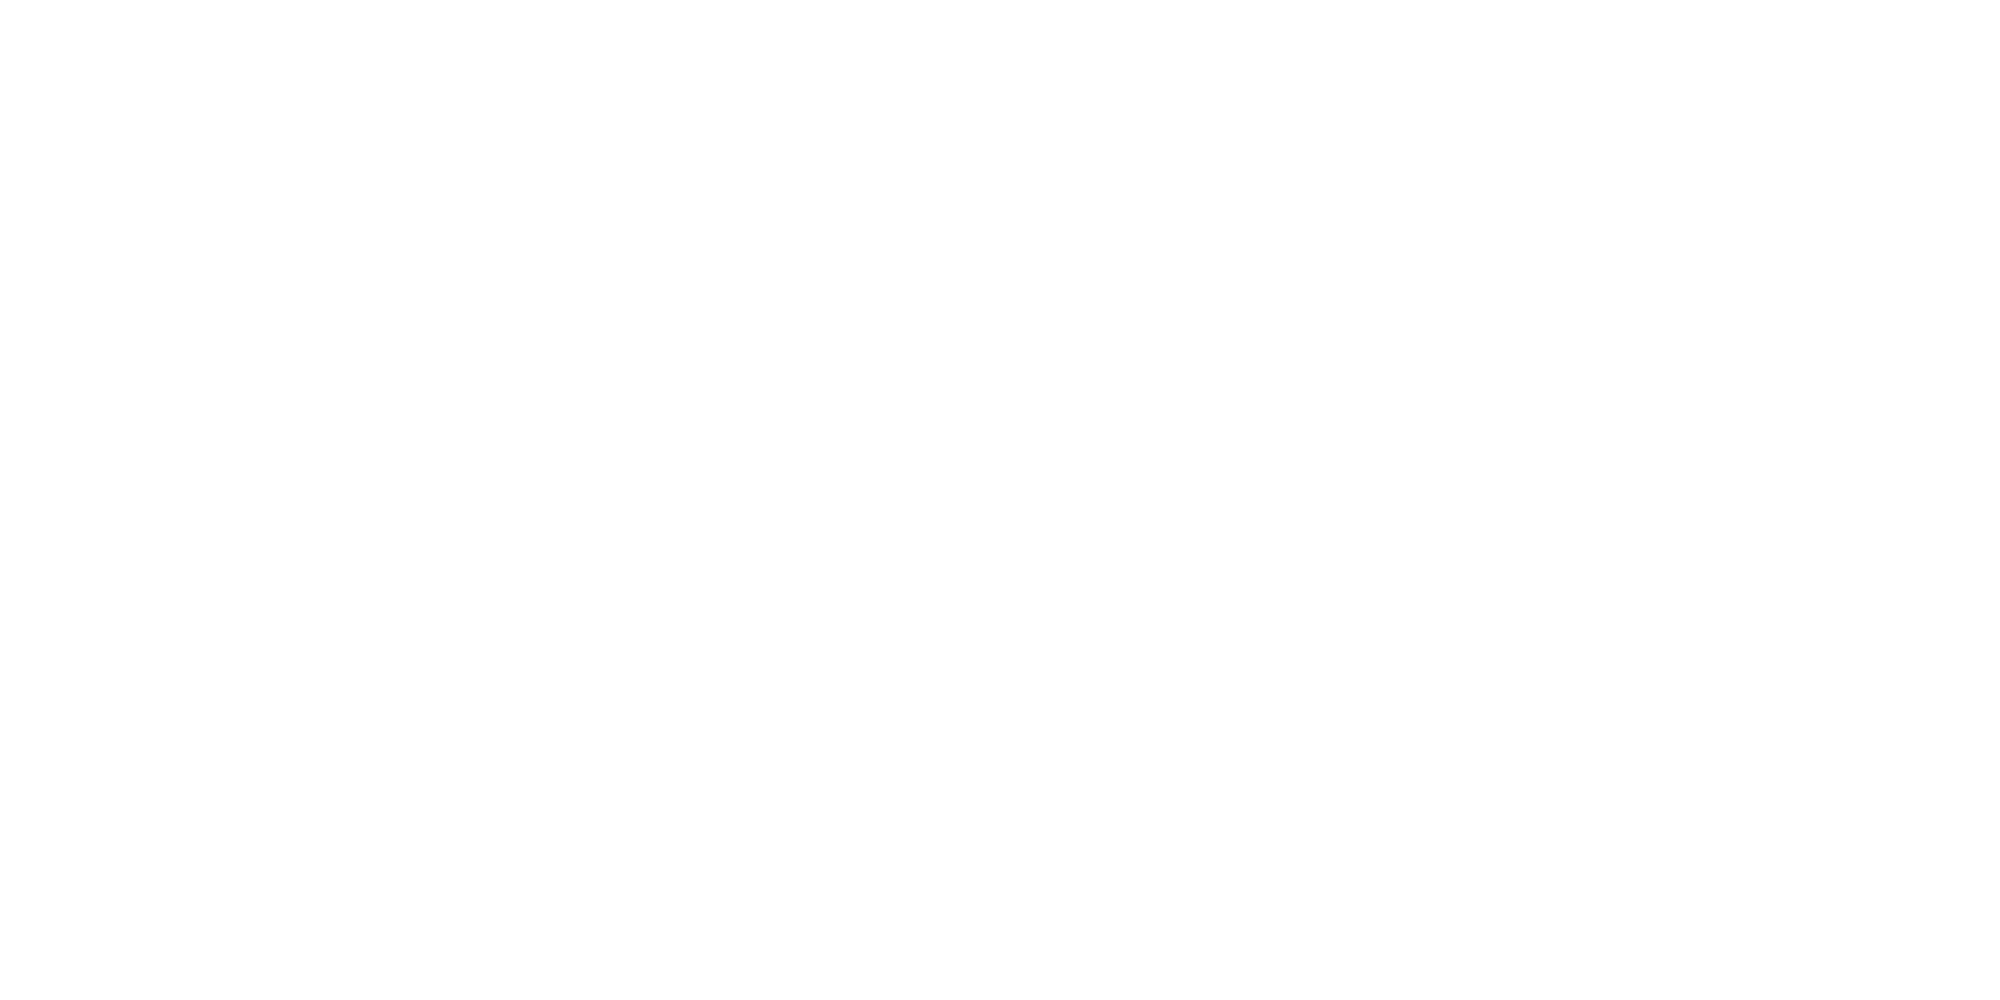

<IPython.core.display.Javascript object>


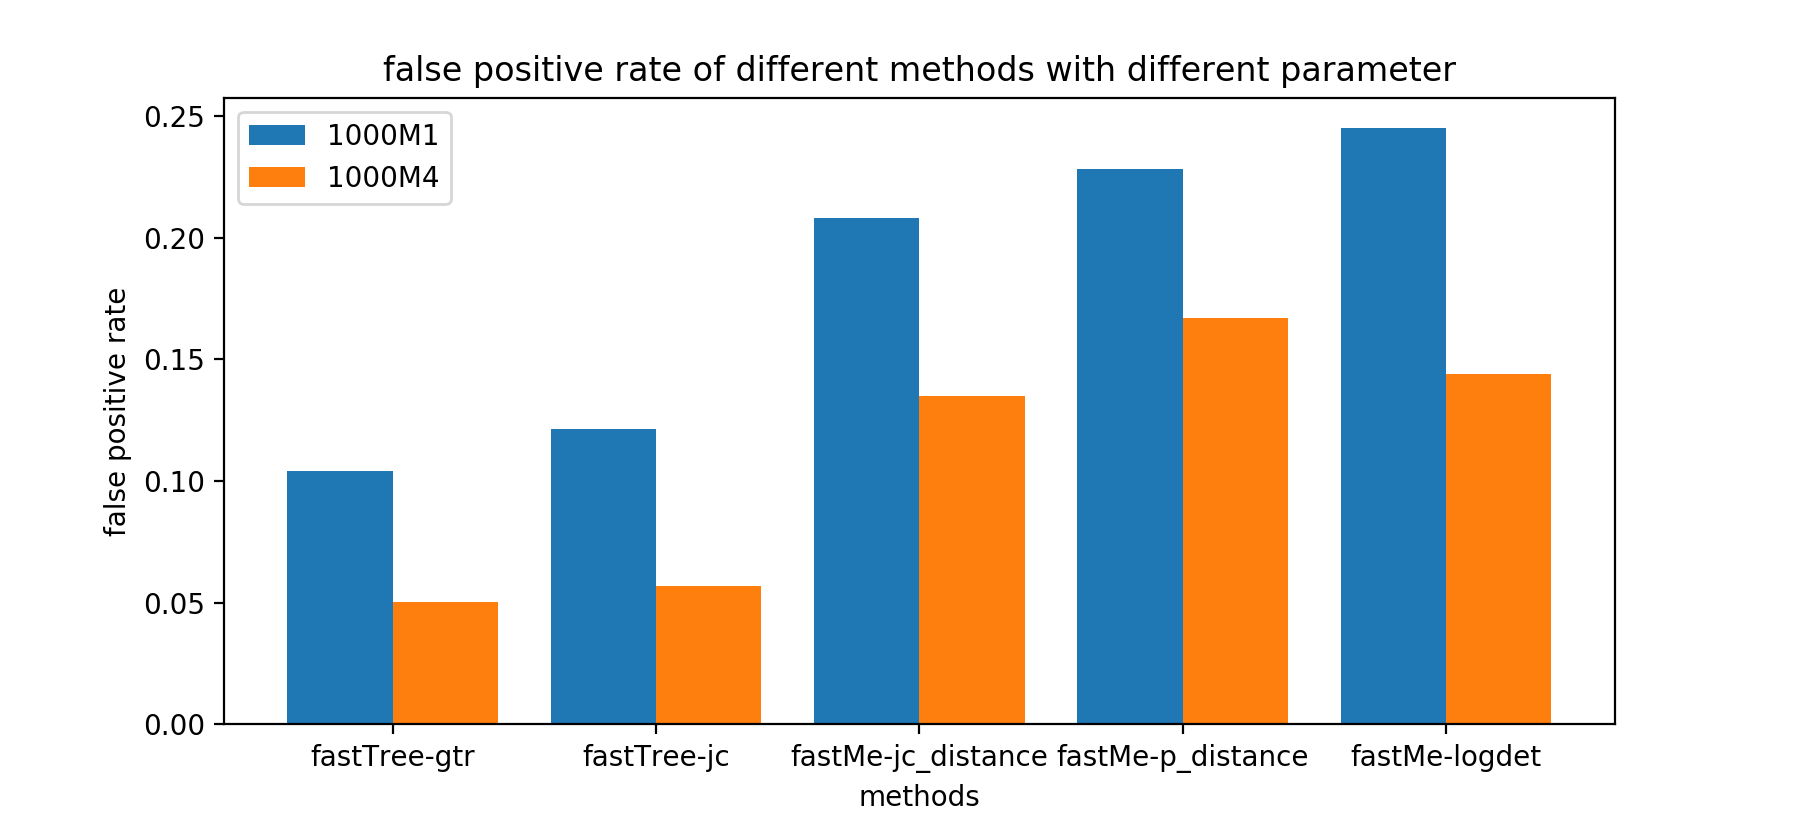

In [45]:
#plot the false positive rate of different method
label = ["fastTree-gtr", "fastTree-jc", "fastMe-jc_distance", "fastMe-p_distance", "fastMe-logdet"]
m1 = [ft_gtr_fp[0], ft_jc_fp[0], fm_jc_fp[0], fm_p_fp[0], fm_l_fp[0]]
m4 = [ft_gtr_fp[1], ft_jc_fp[1], fm_jc_fp[1], fm_p_fp[1], fm_l_fp[1]]
_X = np.arange(len(label))

plt.figure(figsize=(10,5))

fig, ax = plt.subplots()
ax.bar(_X-0.2, m1, 0.4, label="1000M1")
ax.bar(_X+0.2, m4, 0.4, label="1000M4")
ax.set_xticks(_X)
ax.set_xticklabels(label)
ax.set_xlabel("methods")
ax.set_ylabel("false positive rate")
ax.set_title("false positive rate of different methods with different parameter")
ax.legend()

plt.show()

<IPython.core.display.Javascript object>


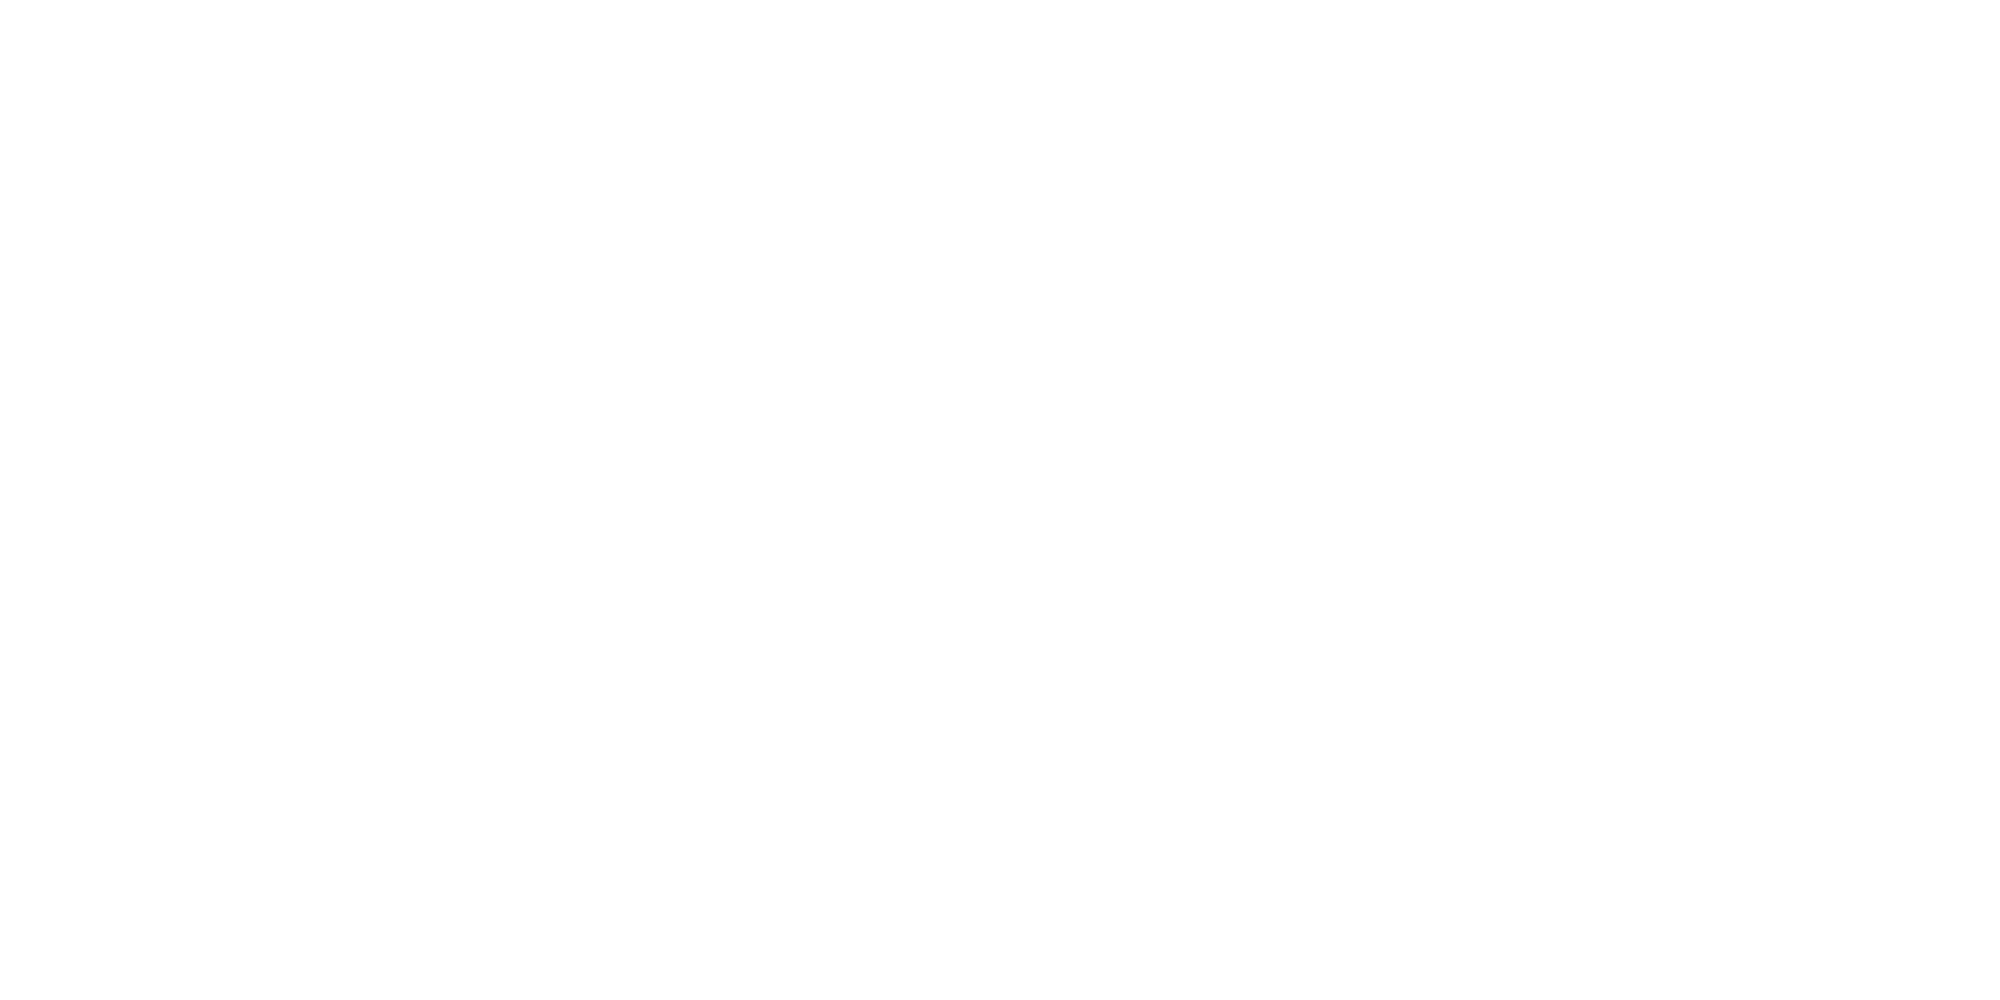

<IPython.core.display.Javascript object>


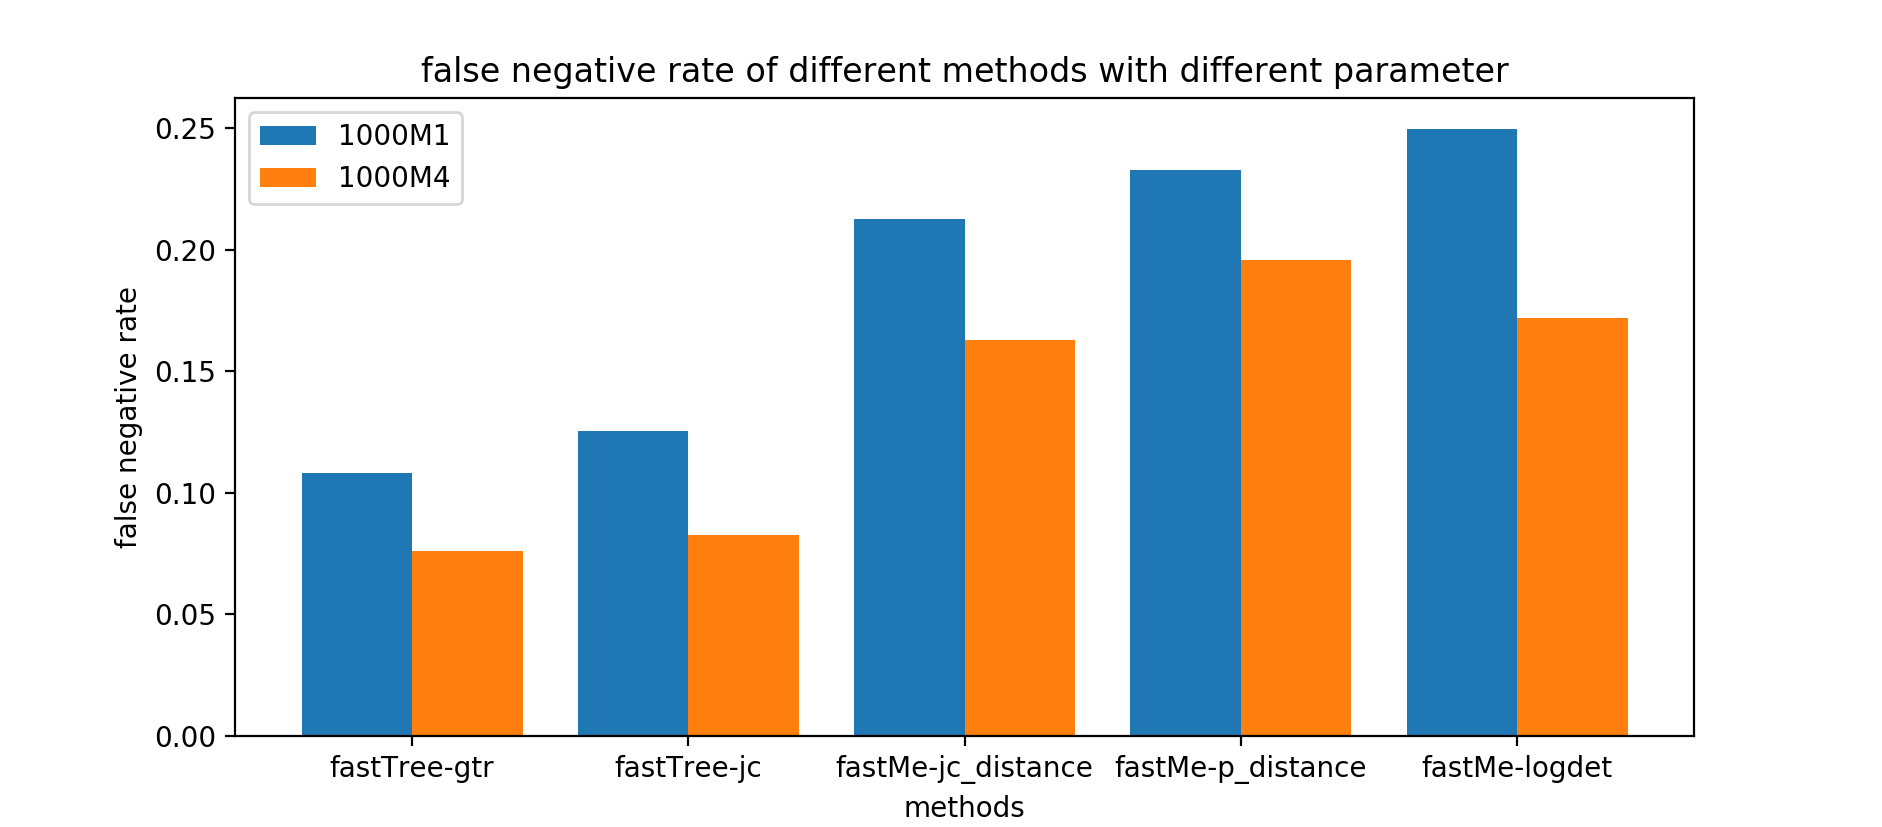

In [46]:
#plot the false negative rate of different method
m1 = [ft_gtr_fn[0], ft_jc_fn[0], fm_jc_fn[0], fm_p_fn[0], fm_l_fn[0]]
m4 = [ft_gtr_fn[1], ft_jc_fn[1], fm_jc_fn[1], fm_p_fn[1], fm_l_fn[1]]
_X = np.arange(len(label))

plt.figure(figsize=(10,5))

fig, ax = plt.subplots()
ax.bar(_X-0.2, m1, 0.4, label="1000M1")
ax.bar(_X+0.2, m4, 0.4, label="1000M4")
ax.set_xticks(_X)
ax.set_xticklabels(label)
ax.set_xlabel("methods")
ax.set_ylabel("false negative rate")
ax.set_title("false negative rate of different methods with different parameter")
ax.legend()

plt.show()